In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
# 1. Load the data
df = pd.read_csv("D:\Credit Card Transaction Fraud Detection\Churn_Modelling.csv") # Replace with your actual file path

In [3]:
print(df.head())

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

In [4]:
# 2. Data Exploration and Preprocessing

# Drop unnecessary columns like RowNumber, CustomerId, and Surname
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
print("\nData Info:")
print(df.info())


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB
None


In [5]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())  #Shows number of missing values in each column


Missing Values:
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [6]:
# Imputation strategy
#Numerical features: mean imputation
#Categorical features: mode imputation
numerical_cols = df.select_dtypes(include=np.number).columns
categorical_cols = df.select_dtypes(exclude=np.number).columns

numerical_imputer = SimpleImputer(strategy='mean') #Mean is common
df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])

categorical_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

In [7]:
# Verify that missing values have been handled
print("\nMissing Values After Imputation:")
print(df.isnull().sum())


Missing Values After Imputation:
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [8]:
# 3. Feature Engineering and Encoding

# Create a ColumnTransformer to apply different transformations to different columns
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary'] #List all numerical columns
categorical_features = ['Geography', 'Gender'] #Categorical columns

# Using make_column_transformer() for conciseness
ct = ColumnTransformer(
    [
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # 'handle_unknown' important to avoid errors
    ],
    remainder='passthrough' # Include the remaining columns
)

In [9]:
# 4. Model Building

# Define features (X) and target (y)
X = df.drop('Exited', axis=1)
y = df['Exited']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% training, 20% testing

In [10]:
# Logistic Regression
pipeline_lr = Pipeline([
    ('transformer', ct),
    ('classifier', LogisticRegression(random_state=42))
])
pipeline_rf = Pipeline([
    ('transformer', ct),
    ('classifier', RandomForestClassifier(random_state=42))
])
#Hyperparameter Tuning using GridSearchCV
#Define the grid of hyperparameters to search
# Logistic Regression parameters
param_grid_lr = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'saga']
}

In [11]:
# Random Forest parameters
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [4, 6, 8, 10],
    'classifier__min_samples_split': [2, 4, 6]
}
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, scoring='roc_auc', cv=3)
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, scoring='roc_auc', cv=3) #CV=3 is a common value

In [12]:
# Fit the GridSearchCV objects
grid_search_lr.fit(X_train, y_train)
grid_search_rf.fit(X_train, y_train)

C:\Python 311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Python 311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Python 311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Python 311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Python 311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Python 311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['CreditScore',
                                                                          'Age',
                                                                          'Tenure',
                                                                          'Balance',
                                                                          'NumOfProducts',
                                                                          'EstimatedSalary']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Geography',
                                                                          'Gender'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [4, 6, 8, 10],
                         'classifier__min_samples_split': [2, 4, 6],
                         'classifier__n_estimators': [100, 200, 300]},
             scoring='roc_auc')

In [13]:
# Make predictions on the test data
y_pred_lr = grid_search_lr.predict(X_test)
y_pred_rf = grid_search_rf.predict(X_test)

In [14]:
# Calculate evaluation metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, grid_search_lr.predict_proba(X_test)[:, 1])

In [15]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, grid_search_rf.predict_proba(X_test)[:, 1])

In [16]:
# Print the evaluation metrics
print("Logistic Regression Metrics:")
print("Accuracy:", accuracy_lr)
print("Precision:", precision_lr)
print("Recall:", recall_lr)
print("F1 Score:", f1_lr)
print("AUC-ROC:", roc_auc_lr)

Logistic Regression Metrics:
Accuracy: 0.8105
Precision: 0.5673076923076923
Recall: 0.15012722646310434
F1 Score: 0.23742454728370221
AUC-ROC: 0.781908349444463


In [17]:
print("\nRandom Forest Metrics:")
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1 Score:", f1_rf)
print("AUC-ROC:", roc_auc_rf)


Random Forest Metrics:
Accuracy: 0.867
Precision: 0.7847533632286996
Recall: 0.44529262086513993
F1 Score: 0.5681818181818182
AUC-ROC: 0.8710064587024643


In [18]:
#Feature importance:
rf_model = grid_search_rf.best_estimator_.named_steps['classifier']
feature_importances = rf_model.feature_importances_

In [20]:
# Ensure the ColumnTransformer is fitted
ct.fit(X_train)  # Replace X_train with your actual dataset

# Now access named transformers
feature_names = (
    ct.named_transformers_['num'].get_feature_names_out(numerical_features).tolist() +
    ct.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist() +
    ['HasCrCard', 'IsActiveMember', 'Tenure', 'Balance', 'NumOfProducts', 'CreditScore']
)

feature_importance_dict = dict(zip(feature_names, feature_importances))


In [21]:
# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

In [22]:
#Print top 10 features
print('\nTop 10 features:')
for feature, importance in sorted_features[:10]:
    print(f"{feature}: {importance}")


Top 10 features:
Age: 0.3109298732565346
NumOfProducts: 0.23460163699382225
Balance: 0.10454057467706002
CreditScore: 0.07723756052200251
EstimatedSalary: 0.07506256795768483
IsActiveMember: 0.06737189327392121
Tenure: 0.04153551853344917
Geography_Germany: 0.03570219727386415
Gender_Female: 0.011977022989230082
Geography_France: 0.011882179805241672


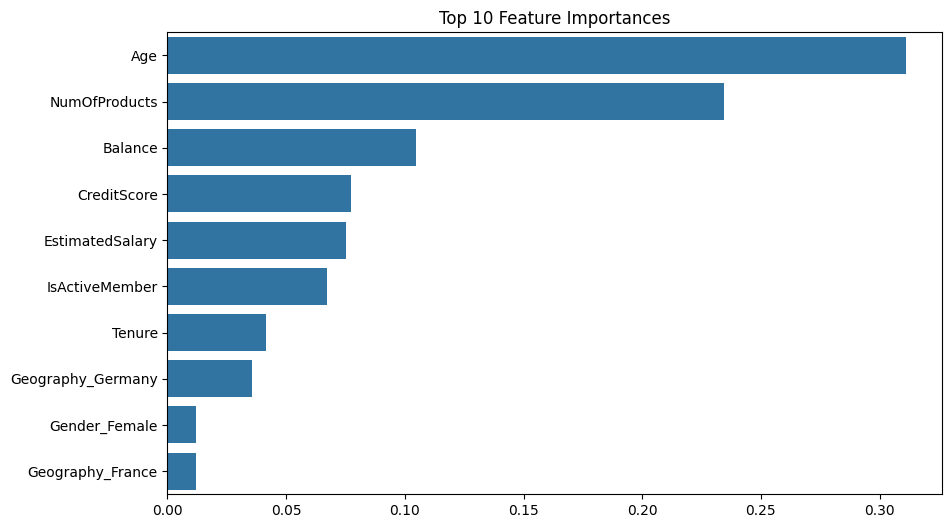

In [23]:
# Visualization of feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=[importance for feature, importance in sorted_features[:10]], y=[feature for feature, importance in sorted_features[:10]])
plt.title("Top 10 Feature Importances")
plt.show()